# Credit Card Customers (BankChurners) Аникин Максим

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

PROJECT_ROOT = Path('.').resolve()
DATA_PATH = PROJECT_ROOT / 'data' / 'raw' / 'BankChurners.csv'

plt.rcParams['figure.figsize'] = (8, 5)
DATA_PATH

PosixPath('/home/decll/Документы/ML-HW/HW3&7/data/raw/BankChurners.csv')

## ДЗ3. Обучение с учителем (классификация)

### 0) Постановка задачи
Нужно предсказать **отток клиента** по данным о клиенте и его активности по кредитной карте.

- Целевая переменная: **флаг оттока** (`Attrition_Flag`)  
- Классы: `Existing Customer` (остался) и `Attrited Customer` (ушёл)  
- Тип задачи: **бинарная классификация**


### 1) Чтение данных

In [3]:
if not DATA_PATH.exists():
    raise FileNotFoundError(
        f"Не найден файл: {DATA_PATH}.\n"
        "Скачайте BankChurners.csv с Kaggle и положите в data/raw/"
    )

df_raw = pd.read_csv(DATA_PATH)
print("Shape (raw):", df_raw.shape)
df_raw.head()

Shape (raw): (10127, 23)


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


Очистка: удаляем неинформативные/служебные столбцы (ID и Naive Bayes колонки, если есть).

In [4]:
df = df_raw.copy()

df = df.drop(columns=['CLIENTNUM'], errors='ignore')

nb_cols = [c for c in df.columns if c.startswith('Naive_Bayes_Classifier') or 'Naive_Bayes' in c]
df = df.drop(columns=nb_cols, errors='ignore')

print("Shape (clean):", df.shape)
df.head()

Shape (clean): (10127, 20)


,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


### 2) Разбиение на обучающую и тестовую выборки
Для задачи классификации используем стратифицированное разбиение по целевой переменной.


In [33]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

TARGET = 'Attrition_Flag'

X = df.drop(columns=[TARGET])
y = df[TARGET]

le_y = LabelEncoder()
y_enc = le_y.fit_transform(y)

N = len(df)
d = X.shape[1]
K = len(np.unique(y_enc))

print(f"N (объектов) = {N}")
print(f"d (признаков до кодирования) = {d}")
print(f"K (классов) = {K} -> {list(le_y.classes_)}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

X_train.shape, X_test.shape

N (объектов) = 10127
d (признаков до кодирования) = 19
K (классов) = 2 -> ['Attrited Customer', 'Existing Customer']


((8101, 19), (2026, 19))

### 3) Визуализация и основные характеристики (EDA)

In [ ]:
class_dist = pd.Series(y_enc).value_counts().sort_index()
class_dist.index = le_y.inverse_transform(class_dist.index)
class_dist = class_dist.to_frame('count')
class_dist['share'] = class_dist['count'] / class_dist['count'].sum()
display(class_dist)

cat_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]
print("Категориальных признаков:", len(cat_cols))
print("Числовых признаков:", len(num_cols))
print("Примеры категориальных:", cat_cols[:5])
print("Примеры числовых:", num_cols[:5])

,count,share
Attrited Customer,1627,0.16066
Existing Customer,8500,0.83934


Категориальных признаков: 5
Числовых признаков: 14
Примеры категориальных: ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']
Примеры числовых: ['Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon']


In [ ]:
num_stats = X[num_cols].describe().T
display(num_stats.head(20))

,count,mean,std,min,25%,50%,75%,max
Customer_Age,10127.0,46.325960,8.016814,26.0,41.000,46.000,52.000,73.000
Dependent_count,10127.0,2.346203,1.298908,0.0,1.000,2.000,3.000,5.000
Months_on_book,10127.0,35.928409,7.986416,13.0,31.000,36.000,40.000,56.000
Total_Relationship_Count,10127.0,3.812580,1.554408,1.0,3.000,4.000,5.000,6.000
Months_Inactive_12_mon,10127.0,2.341167,1.010622,0.0,2.000,2.000,3.000,6.000
Contacts_Count_12_mon,10127.0,2.455317,1.106225,0.0,2.000,2.000,3.000,6.000
Credit_Limit,10127.0,8631.953698,9088.776650,1438.3,2555.000,4549.000,11067.500,34516.000
Total_Revolving_Bal,10127.0,1162.814061,814.987335,0.0,359.000,1276.000,1784.000,2517.000
Avg_Open_To_Buy,10127.0,7469.139637,9090.685324,3.0,1324.500,3474.000,9859.000,34516.000
Total_Amt_Chng_Q4_Q1,10127.0,0.759941,0.219207,0.0,0.631,0.736,0.859,3.397


#### Корреляционная матрица
Покажем корреляцию числовых признаков **между собой** и отдельно — корреляцию **с целевой переменной** (учителем).  
Подсветим сильные связи по модулю (например, |corr| ≥ 0.7).


Топ-15 корреляций с целевой переменной (по модулю):


,corr_with_target
Total_Trans_Ct,0.371403
Total_Ct_Chng_Q4_Q1,0.290054
Total_Revolving_Bal,0.263053
Contacts_Count_12_mon,-0.204491
Avg_Utilization_Ratio,0.178410
Total_Trans_Amt,0.168598
Months_Inactive_12_mon,-0.152449
Total_Relationship_Count,0.150005
Total_Amt_Chng_Q4_Q1,0.131063
Credit_Limit,0.023873


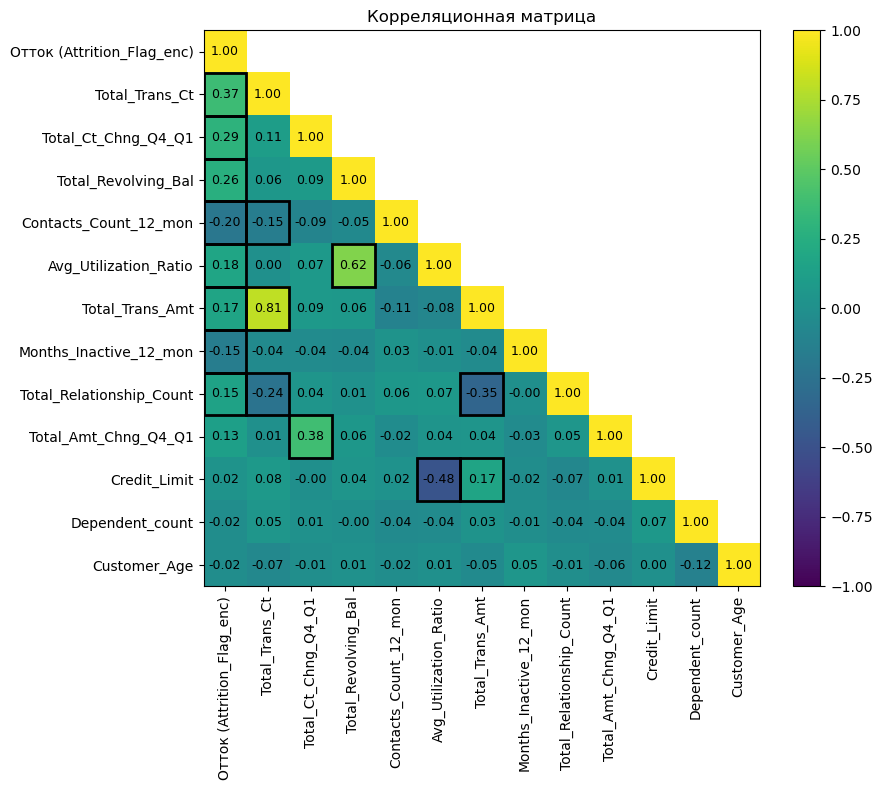

In [48]:
df_corr = X[num_cols].copy()
df_corr['Отток (Attrition_Flag_enc)'] = y_enc

corr = df_corr.corr(numeric_only=True)

target_col = 'Отток (Attrition_Flag_enc)'
corr_with_target = (corr[target_col]
                    .drop(target_col)
                    .sort_values(key=lambda s: s.abs(), ascending=False))

print("Топ-15 корреляций с целевой переменной (по модулю):") 
display(corr_with_target.head(15).to_frame('corr_with_target'))

topN = 12
top_features = corr_with_target.head(topN).index.tolist()
cols_for_plot = [target_col] + top_features
corr_small = corr.loc[cols_for_plot, cols_for_plot]
mask = np.triu(np.ones_like(corr_small, dtype=bool), k=1)

plt.figure(figsize=(10, 8))
im = plt.imshow(corr_small, vmin=-1, vmax=1)

im.set_array(np.ma.masked_where(mask, corr_small))

plt.colorbar(im, fraction=0.046, pad=0.04)

plt.xticks(range(len(cols_for_plot)), cols_for_plot, rotation=90)
plt.yticks(range(len(cols_for_plot)), cols_for_plot)

threshold = 0.15
for i in range(corr_small.shape[0]):
    for j in range(corr_small.shape[1]):
        if mask[i, j]:
            continue
        val = corr_small.iat[i, j]
        plt.text(j, i, f"{val:.2f}", ha='center', va='center', fontsize=9)
        if (i != j) and (abs(val) >= threshold):
            plt.gca().add_patch(
                plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=False, linewidth=2)
            )

plt.title("Корреляционная матрица")
plt.tight_layout()
plt.show()

#### Гистограммы ключевых поведенческих признаков
Показывают распределение значений по клиентам (по оси Y — количество клиентов).


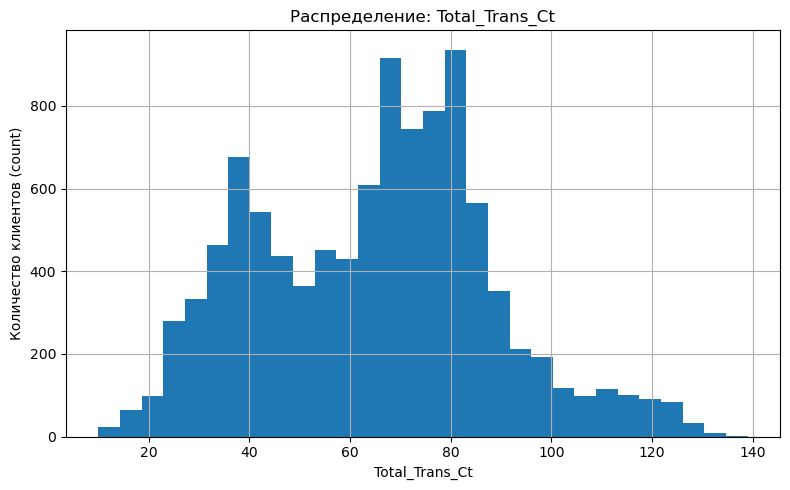

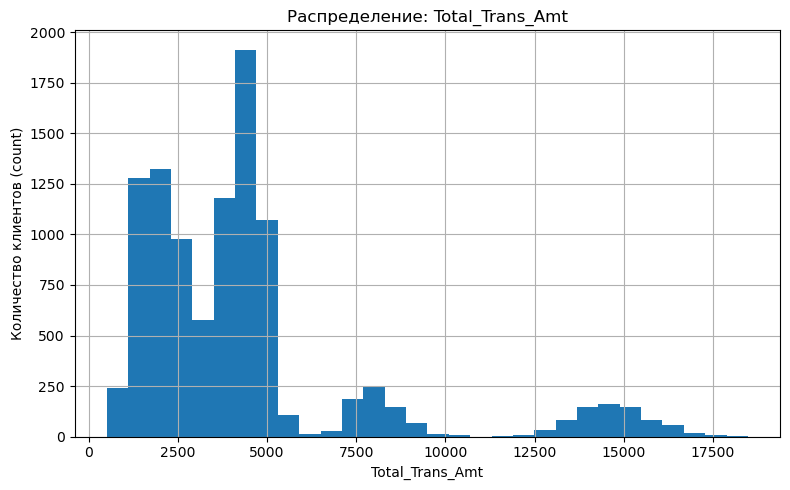

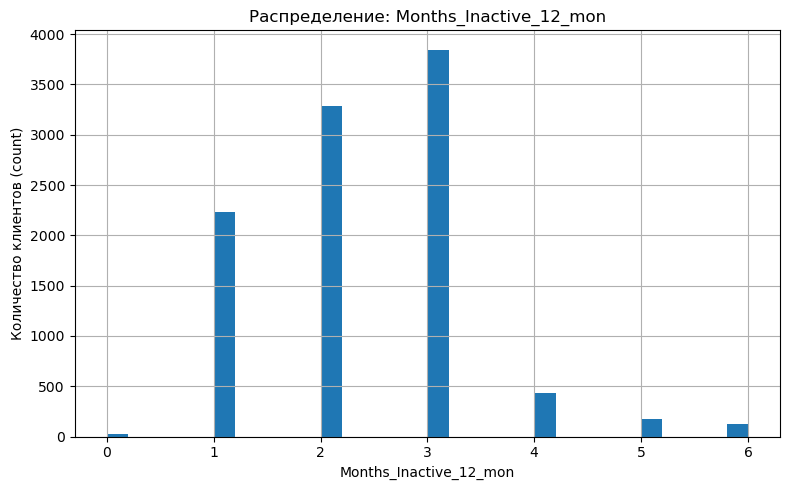

In [10]:
for col in ['Total_Trans_Ct', 'Total_Trans_Amt', 'Months_Inactive_12_mon']:
    if col in X.columns:
        plt.figure()
        X[col].hist(bins=30)
        plt.title(f"Распределение: {col}")
        plt.xlabel(col)
        plt.ylabel("Количество клиентов (count)")
        plt.tight_layout()
        plt.show()

### 4) Пропущенные значения 

In [49]:
missing = (df.isna().sum()
           .to_frame('missing_count')
           .assign(missing_pct=lambda t: 100*t['missing_count']/len(df))
           .sort_values('missing_count', ascending=False))
display(missing.head(30))

,missing_count,missing_pct
Attrition_Flag,0,0.0
Customer_Age,0,0.0
Gender,0,0.0
Dependent_count,0,0.0
Education_Level,0,0.0
Marital_Status,0,0.0
Income_Category,0,0.0
Card_Category,0,0.0
Months_on_book,0,0.0
Total_Relationship_Count,0,0.0


### 5–6) Категориальные признаки + нормализация
- Категориальные признаки кодируем One-Hot (`OneHotEncoder`)
- Числовые нормализуем (`StandardScaler`), **потому что kNN использует расстояния**


In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

numeric_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipe, num_cols),
    ('cat', categorical_pipe, cat_cols)
])

preprocessor

,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for formatting. The given string will be formatted using two field names: ``transformer_name`` and ``feature_name``. e.g. `

### 7) Запуск классификатора и аргументация выбора
Используем **k ближайших соседей** (`KNeighborsClassifier`):
- простой базовый метод,
- хорошо демонстрирует влияние нормализации,
- есть понятный гиперпараметр `k` (число соседей).


In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.dummy import DummyClassifier

baseline = Pipeline([
    ('prep', preprocessor),
    ('clf', DummyClassifier(strategy='most_frequent'))
])
baseline.fit(X_train, y_train)

pred_base = baseline.predict(X_test)
print("Baseline (DummyClassifier) — TEST")
print(confusion_matrix(y_test, pred_base))
print(classification_report(le_y.inverse_transform(y_test),
                            le_y.inverse_transform(pred_base),
                            zero_division=0))

Baseline (DummyClassifier) — TEST
[[   0  325]
 [   0 1701]]
                   precision    recall  f1-score   support

Attrited Customer       0.00      0.00      0.00       325
Existing Customer       0.84      1.00      0.91      1701

         accuracy                           0.84      2026
        macro avg       0.42      0.50      0.46      2026
     weighted avg       0.70      0.84      0.77      2026



### 8) Ошибки на train/test, матрица рассогласования, подбор оптимального k
Подбираем `k` (и ещё пару параметров) через `GridSearchCV` (cv=5) по метрике `f1_macro`.


In [16]:
knn_pipe = Pipeline([
    ('prep', preprocessor),
    ('clf', KNeighborsClassifier())
])

param_grid = {
    'clf__n_neighbors': list(range(1, 41)),
    'clf__weights': ['uniform', 'distance'],
    'clf__p': [1, 2]
}

gs = GridSearchCV(
    knn_pipe,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1
)
gs.fit(X_train, y_train)

print("Best params:", gs.best_params_)
print("Best CV f1_macro:", gs.best_score_)

best_model = gs.best_estimator_

Best params: {'clf__n_neighbors': 6, 'clf__p': 1, 'clf__weights': 'uniform'}
Best CV f1_macro: 0.821618715152554


In [17]:
for name, X_split, y_split in [('TRAIN', X_train, y_train), ('TEST', X_test, y_test)]:
    pred = best_model.predict(X_split)
    print(f"\n=== {name} ===")
    print("Confusion matrix:")
    print(confusion_matrix(y_split, pred))
    print("\nReport:")
    print(classification_report(le_y.inverse_transform(y_split),
                                le_y.inverse_transform(pred),
                                zero_division=0))


=== TRAIN ===
Confusion matrix:
[[ 954  348]
 [ 149 6650]]

Report:
                   precision    recall  f1-score   support

Attrited Customer       0.86      0.73      0.79      1302
Existing Customer       0.95      0.98      0.96      6799

         accuracy                           0.94      8101
        macro avg       0.91      0.86      0.88      8101
     weighted avg       0.94      0.94      0.94      8101


=== TEST ===
Confusion matrix:
[[ 205  120]
 [  63 1638]]

Report:
                   precision    recall  f1-score   support

Attrited Customer       0.76      0.63      0.69       325
Existing Customer       0.93      0.96      0.95      1701

         accuracy                           0.91      2026
        macro avg       0.85      0.80      0.82      2026
     weighted avg       0.90      0.91      0.91      2026



### 9) (Дополнительно) Другие классификаторы и сравнение
Для сравнения добавим логистическую регрессию и случайный лес.


In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

models = {
    'kNN(best)': best_model,
    'LogReg': Pipeline([
        ('prep', preprocessor),
        ('clf', LogisticRegression(max_iter=2000))
    ]),
    'RandomForest': Pipeline([
        ('prep', preprocessor),
        ('clf', RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1))
    ])
}

rows = []
for mname, model in models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    rows.append((mname, f1_score(y_test, pred, average='macro')))

res_models = pd.DataFrame(rows, columns=['model', 'f1_macro(TEST)']).sort_values('f1_macro(TEST)', ascending=False)
display(res_models)

,model,f1_macro(TEST)
2,RandomForest,0.913771
0,kNN(best),0.819247
1,LogReg,0.789998


### 10) (Дополнительно) Борьба с дисбалансом классов
Покажем пример: логистическая регрессия с `class_weight='balanced'`.


In [26]:
logreg_bal = Pipeline([
    ('prep', preprocessor),
    ('clf', LogisticRegression(max_iter=2000, class_weight='balanced'))
])
logreg_bal.fit(X_train, y_train)
pred_bal = logreg_bal.predict(X_test)

print("LogReg balanced — TEST")
print(confusion_matrix(y_test, pred_bal))
print(classification_report(le_y.inverse_transform(y_test),
                            le_y.inverse_transform(pred_bal),
                            zero_division=0))

LogReg balanced — TEST
[[ 272   53]
 [ 263 1438]]
                   precision    recall  f1-score   support

Attrited Customer       0.51      0.84      0.63       325
Existing Customer       0.96      0.85      0.90      1701

         accuracy                           0.84      2026
        macro avg       0.74      0.84      0.77      2026
     weighted avg       0.89      0.84      0.86      2026



### 11) (Дополнительно) Исключение сильно коррелированных переменных
Найдём пары числовых признаков с |corr| ≥ 0.9.


In [27]:
corr_num = X[num_cols].corr()
thr = 0.9

pairs = []
cols = corr_num.columns
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        c = corr_num.iat[i, j]
        if abs(c) >= thr:
            pairs.append((cols[i], cols[j], c))

pairs_df = pd.DataFrame(pairs, columns=['feature_1', 'feature_2', 'corr']).sort_values('corr', key=lambda s: s.abs(), ascending=False)
display(pairs_df.head(20))

,feature_1,feature_2,corr
0,Credit_Limit,Avg_Open_To_Buy,0.995981


### 12) Выводы (ДЗ3)
Корреляционный анализ показал, что наибольшую связь с оттоком имеют поведенческие признаки, прежде всего количество транзакций (Total_Trans_Ct) и показатели изменения активности, тогда как демографические признаки практически не влияют на целевую переменную. Для решения задачи был выбран метод k ближайших соседей, так как он чувствителен к масштабу признаков и требует нормализации, что делает влияние предобработки наглядным. В результате подбора гиперпараметров оптимальным оказалось значение k = 6 с манхэттенской метрикой расстояния, при этом модель достигла значения F1-macro около 0.82. Анализ матрицы рассогласования показал, что основная часть ошибок связана с недовыявлением клиентов с оттоком, что обусловлено несбалансированностью классов, однако модель значительно превосходит базовый классификатор.


## ДЗ7. Кластеризация (обучение без учителя)

- При обучении кластеризаторов **НЕ используем y**
- После обучения **сравниваем** полученные кластеры с истинными метками через ARI/NMI
- Визуализация — PCA (2D)


### 1) Подготовка данных для кластеризации (препроцессинг без y)

In [28]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

X_all = preprocessor.fit_transform(X)  # fit без y
X_dense = X_all.toarray() if hasattr(X_all, 'toarray') else X_all
print("X_all shape:", X_all.shape)

X_all shape: (10127, 37)


### 2) PCA (2 компоненты)

In [29]:
pca2 = PCA(n_components=2, random_state=42)
X_2d = pca2.fit_transform(X_dense)

print("Explained variance ratio:", pca2.explained_variance_ratio_)
print("Total explained variance:", pca2.explained_variance_ratio_.sum())

Explained variance ratio: [0.16208587 0.12274595]
Total explained variance: 0.2848318211655327


### 3) Кластеризация: KMeans, DBSCAN, Agglomerative

In [30]:
kmeans = KMeans(n_clusters=2, random_state=42, n_init='auto')
labels_km = kmeans.fit_predict(X_all)

dbscan = DBSCAN(eps=0.8, min_samples=10)
labels_db = dbscan.fit_predict(X_all)

agg = AgglomerativeClustering(n_clusters=2, linkage='ward')
labels_ag = agg.fit_predict(X_dense)

set(labels_km), set(labels_db), set(labels_ag)

({0, 1}, {-1}, {0, 1})

### 4) Метрики качества кластеризации + сравнение с истинными метками

In [31]:
def evaluate_clustering(name, labels):
    labels = np.asarray(labels)
    uniq = sorted(set(labels.tolist()))
    n_noise = int(np.sum(labels == -1)) if -1 in uniq else 0

    sil = np.nan
    dbi = np.nan
    mask = labels != -1
    uniq_wo_noise = sorted(set(labels[mask].tolist()))
    if len(uniq_wo_noise) >= 2 and mask.sum() > 2:
        sil = float(silhouette_score(X_all[mask], labels[mask]))
        dbi = float(davies_bouldin_score(X_dense[mask], labels[mask]))

    ari = float(adjusted_rand_score(y_enc, labels))
    nmi = float(normalized_mutual_info_score(y_enc, labels))

    return {
        'algo': name,
        'labels_unique': uniq,
        'n_noise': n_noise,
        'silhouette': sil,
        'davies_bouldin': dbi,
        'ARI': ari,
        'NMI': nmi
    }

res = pd.DataFrame([
    evaluate_clustering('KMeans', labels_km),
    evaluate_clustering('DBSCAN', labels_db),
    evaluate_clustering('Agglomerative', labels_ag),
])
display(res)

,algo,labels_unique,n_noise,silhouette,davies_bouldin,ARI,NMI
0,KMeans,"[0, 1]",0,0.157329,2.300252,-0.015618,0.000915
1,DBSCAN,[-1],10127,NaN,NaN,0.000000,0.000000
2,Agglomerative,"[0, 1]",0,0.167826,2.383111,-0.045024,0.007500


### 5) Визуализация в PCA-2D

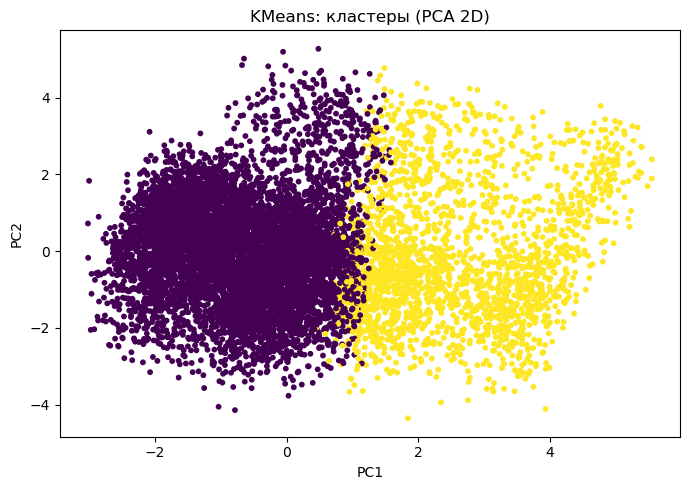

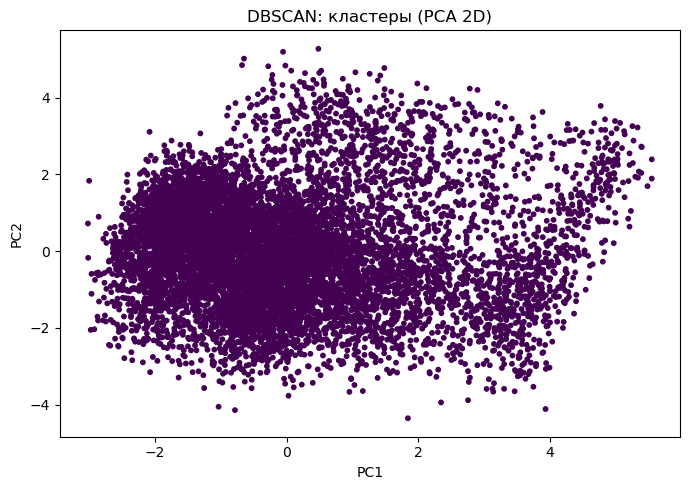

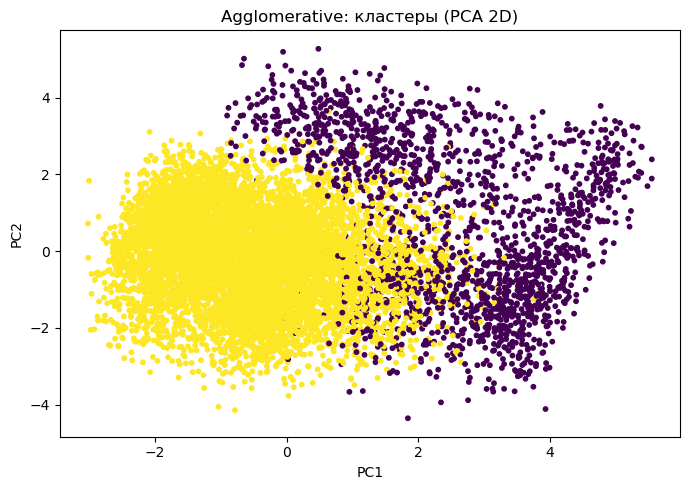

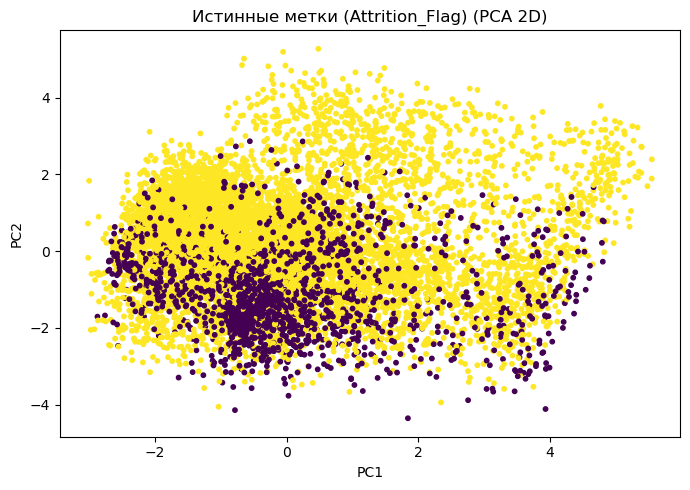

In [32]:
def plot_pca_scatter(labels, title):
    plt.figure(figsize=(7, 5))
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, s=10)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_pca_scatter(labels_km, "KMeans: кластеры (PCA 2D)")
plot_pca_scatter(labels_db, "DBSCAN: кластеры (PCA 2D)")
plot_pca_scatter(labels_ag, "Agglomerative: кластеры (PCA 2D)")
plot_pca_scatter(y_enc, "Истинные метки (Attrition_Flag) (PCA 2D)")

### 6) Выводы (ДЗ7)
PCA-визуализация показала сильное перекрытие объектов и отсутствие чёткой кластерной структуры, соответствующей оттоку клиентов. Алгоритмы KMeans и агломеративная кластеризация формально разбивают данные, но полученные кластеры слабо совпадают с истинными метками, что подтверждается низкими значениями ARI и NMI. DBSCAN не смог выделить устойчивые кластеры и оказался чувствителен к выбору параметров. В целом результаты показывают, что отток клиентов лучше решается как задача классификации, а не кластеризации.
